In [5]:
import gym
import gym_anytrading

from gym_anytrading.envs import TradingEnv, ForexEnv, StocksEnv, Actions, Positions 
from gym_anytrading.datasets import FOREX_EURUSD_1H_ASK, STOCKS_GOOGL
import matplotlib.pyplot as plt
from keras import applications
from keras.models import Sequential, Model
from keras.layers import Dense, Activation, Flatten, Dropout, Input, Concatenate, Conv2D, Permute, BatchNormalization
from keras.optimizers import Adam

from rl.agents.dqn import DQNAgent
from rl.agents.ddpg import DDPGAgent
from rl.policy import BoltzmannQPolicy, EpsGreedyQPolicy, LinearAnnealedPolicy
from rl.memory import SequentialMemory
from rl.core import Processor
from rl.random import OrnsteinUhlenbeckProcess
from rl.callbacks import FileLogger, ModelIntervalCheckpoint, TrainIntervalLogger

from sklearn import preprocessing
import warnings
warnings.filterwarnings('ignore')

import json
import numpy as np

In [6]:
class EnvProcessor(Processor):
    def process_observation(self, observation):
        assert observation.ndim == 2  # (height, width, channel)
        return observation#self.process_obs_1(observation)
    
    def process_obs_1(self, observation):
        prices = []
        diff = []
        for o in observation:
            prices.append(o[0])
            diff.append(o[1])
        prices = preprocessing.normalize([prices], norm='l2', axis=1, copy=True, return_norm=False)[0]
        diff = preprocessing.normalize([diff], norm='l2', axis=1, copy=True, return_norm=False)[0]
        new_obs = np.column_stack((prices, diff))
        return new_obs
    
    def process_state_batch(self, batch):
#         print(batch)
        return batch

    def process_reward(self, reward):
        return reward

class DDPGEnvProcessor(EnvProcessor):
    def __init__(self, train_policy, test_policy):
        EnvProcessor.__init__(self)
        self.nb_act_count = [0,0]
        self.count = 0
        self.train_policy = train_policy
        self.test_policy = test_policy
        
    def process_action(self,actions):
        if self.is_train:
            choice = self.train_policy.select_action(q_values=actions)
        else:
            choice = self.test_policy.select_action(q_values=actions)
        self.nb_act_count[choice] +=1
        self.count += 1
        if self.count % 1949 == 0:
            print(self.nb_act_count)
        if self.count % 400 == 0:
            print(actions)
            
        return choice
    def train_mode(self, is_train=True):
        self.is_train = is_train

In [9]:
def env_creator():
    return gym.make('forex-v0', frame_bound=(50, 5000), window_size=10)

env = env_creator()
nb_actions = env.action_space.n

def critic_actor():
    env_shape = (10,2)
    observation_input = Input(shape=(1,) + env_shape, name='observation_input')
    obs = Permute((2, 3, 1), input_shape=(1,) + env_shape)(observation_input)
    obs = Conv2D(filters=64, kernel_size=(2,2), activation='relu', padding='same')(obs)
    obs = BatchNormalization()(obs)
    obs = Conv2D(filters=64, kernel_size=(2,2), activation='relu', padding='same')(obs)
    obs = BatchNormalization()(obs)
    obs = Flatten()(obs)

    obs_1 = Dense(256, activation='relu')(obs)
    obs_1 = Dropout(0.2)(obs_1)
    obs_1 = Dense(64, activation='relu')(obs_1)
    obs_out = Dense(nb_actions, activation='softmax')(obs_1)
    actor = Model(inputs=[observation_input], outputs=obs_out)
    # print(actor.summary())

    obs_2 = Permute((2, 3, 1), input_shape=(1,) + env_shape)(observation_input)
    obs_2 = Conv2D(filters=64, kernel_size=(2,2), activation='relu', padding='same')(obs_2)
    obs_2 = BatchNormalization()(obs_2)
    obs_2 = Conv2D(filters=64, kernel_size=(2,2), activation='relu', padding='same')(obs_2)
    obs_2 = BatchNormalization()(obs_2)
    obs_2 = Flatten()(obs_2)

    action_input = Input(shape=(nb_actions,), name='action_input')
    a1 = Dense(64, activation='linear')(action_input)

    x = Concatenate()([a1, obs])
    x = Dense(256, activation='relu')(x)
    x = Dropout(0.2)(x)
    x = Dense(1)(x)
    x = Activation('linear')(x)
    critic = Model(inputs=[action_input, observation_input], outputs=x)
    # print(critic.summary())
    return actor, critic, action_input

def agent_creator():
    train_policy = LinearAnnealedPolicy(EpsGreedyQPolicy(), attr='eps', value_max=1.0, value_min=0.08, value_test=0.05, nb_steps=10000)
    test_policy = LinearAnnealedPolicy(EpsGreedyQPolicy(), attr='eps', value_max=0.00, value_min=0.00, value_test=0.00, nb_steps=10000)
    processor = DDPGEnvProcessor(train_policy,test_policy)
    processor.train_mode(True)
    memory = SequentialMemory(limit=128, window_length=1)
    actor, critic, action_input = critic_actor()
    random_process = OrnsteinUhlenbeckProcess(size=nb_actions, theta=0.0, mu=0.0, sigma=0.0)
    agent = DDPGAgent(nb_actions=nb_actions, actor=actor, critic=critic, critic_action_input=action_input,
                      memory=memory, nb_steps_warmup_critic=100, nb_steps_warmup_actor=100,
                      random_process=random_process,processor=processor, gamma=1.0, 
                      batch_size=32, train_interval=16)
    agent.compile((Adam(lr=0.05),Adam(lr=0.05)), metrics=['mae'])
    train_policy._set_agent(agent)
    test_policy._set_agent(agent)
    return agent

In [10]:
from evaluator import Evaluator

e = Evaluator(agent_creator, env_creator, name="ddpg")
e.train(repeat=5)

['loss', 'mean_absolute_error', 'mean_q']
starting train 1
------------------ new episode begin, environment reset -----------------------------
Interval 1.0 (0 steps performed)
 83/489 [====>.........................] - ETA: 3s - reward: 0.6229 - cumulative_reward: 45.5711WARNING:tensorflow:From /Users/raymond.djajalaksana/anaconda3/lib/python3.7/site-packages/tensorflow/python/ops/math_ops.py:3066: to_int32 (from tensorflow.python.ops.math_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use tf.cast instead.
489/489 [============================>.] - ETA: 0s - reward: -0.7106 - cumulative_reward: -92.9901
train 1 completed. total_reward: -5.199999999972015 total_profit: 0.8108500975185708
min reward: -203.40000000000026, max reward: 63.40000000000012, mean_reward: -0.002123315639024914

['loss', 'mean_absolute_error', 'mean_q']
starting train 2
------------------ new episode begin, environment reset -----------------------------
Interval 1.0 (0 s

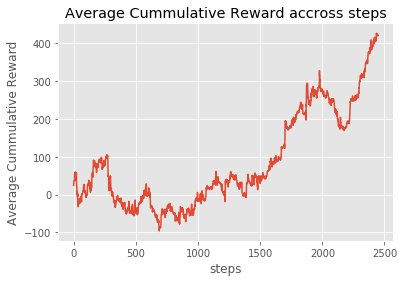

In [11]:
e.process_train_result()

In [19]:
e.agent.test(gym.make('forex-v0', frame_bound=(5000, 6000), window_size=10), visualize=False)

Testing for 1 episodes ...
[0. 1.]
[0. 1.]
[0. 1.]
Episode 1: reward: -147.100, steps: 999
